This is a demo based on the Unet encoder-decoder architecture for evidential semantic segmenatation, which can be run on the google colab.

Please check two points before running the demo:
1. Use GPU or TPU in Google colab to improve the running speed as:
edit >> Notebook setting >> Hardware accelerator >> Select GPU or TPU >> Save.

2. Check the versions of the used libs, especially TensorFlow. The required versions of these libs can be found in the readme file.

The first step is to import the pre-requisite libs as below.
The required versions of these libs can be found in the readme file.

In [14]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
import keras
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sys
print("python版本:%s"% sys.version)
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/fcn_custom/libs')
import ds_layer_p2p #Dempster-Shafer layer for p2p classification
import pt_layer_p2p #pignisitic transform layer
import utility_layer_p2p #Utility layer for imprecision segmenatation

import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.optimize import minimize
import math

2.4.1
python版本:3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Let's get and pre-process the oxford_iiit_pet database.

Here is a simple demo to show the way to use evidential FCN.

Users can replace the database to their own ones or some beachamrk databases, as we reported in our paper.

In [15]:
#Download the oxford_iiit_pet database that is pre-uploaded by tensorflow.datasets and easy to get.
data_train = tfds.load('oxford_iiit_pet:3.*.*', split="train")

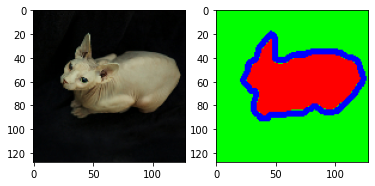

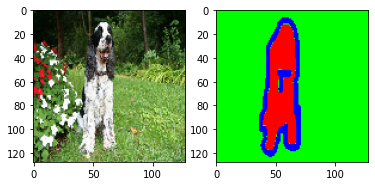

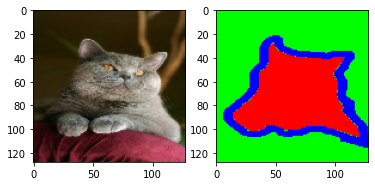

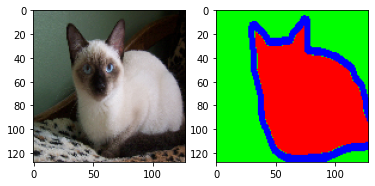

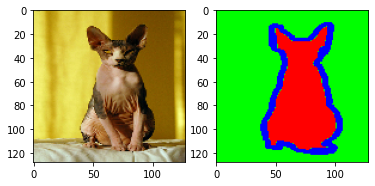

In [16]:
# preprocess the images and masks
# resize images and normalize them
# make the mask labels beign with 0, rather than 1
train_x = []
train_y_label = []
for dataset in data_train:
  train_x.append(tf.image.resize(dataset["image"]/255, (128, 128)))
  train_y_label.append(tf.image.resize(dataset["segmentation_mask"]-1, (128, 128)))

train_x = np.array(train_x)
train_y_label = np.array(train_y_label)
train_y = np_utils.to_categorical(train_y_label)

# let's see some examples
colors = ['red', 'green', 'blue']
cmap = mpl.colors.ListedColormap(colors)
for i in range(5):
    plt.subplot(121)
    plt.imshow(np.squeeze(train_x[i]))
    plt.subplot(122)
    plt.imshow(np.squeeze(train_y[i]), cmap=cmap)
    plt.show()
plt.show()

Let's build a evidential FCN that do not consider the soft labels,
as shown in the next cell.

In the demo, we only have one kind of soft labels 'bound', which is 
the set {pet,backgournd}.

We think 'bound' areas as a mask label if we do not consider them
as soft labels. Thus, we have three classes.

In [17]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=10
num_class=3

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
feature_maps = tf.keras.layers.Conv2D(16, (1, 1), activation='relu')(c9)

ED=ds_layer_p2p.DS1(prototypes, 16)(feature_maps)
ED_ac=ds_layer_p2p.DS1_activate(prototypes)(ED)
mass_prototypes=ds_layer_p2p.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega=ds_layer_p2p.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster=ds_layer_p2p.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
pignistic=pt_layer_p2p.DM_pignistic(num_class)(mass_Dempster)
pignistic=ds_layer_p2p.DS3_normalize()(pignistic)


model_ns = tf.keras.Model(inputs=[inputs], outputs=[pignistic])
model_ns.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy', #MeanAbsoluteError
              metrics=['accuracy'])
model_ns.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        dropout_27[0][0]                 
____________________________________________________________________________________________

Let's train the E-FCN.

In the demo, the weights will be saved if the validation pixel accuracy is improved after one epoch.

We provide a pre-trained E-FCN in 'weights_zoo' file using the first two lines in the next cell.
Users can directly load it, instead of strating with pre-training.

In [ ]:
model_ns.load_weights('/content/gdrive/My Drive/fcn_custom/weights_zoo/pre_train/eUNET_no_softlabel_checkpoint')
model_ns.evaluate(train_x, train_y, batch_size=32, verbose=1)

filepath = '/content/gdrive/My Drive/fcn_custom/weights_zoo/eUNET_no_softlabel_checkpoint'#please define our own filepath to save the weights of the probabilistic FitNet-4 classifier
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)


model_ns.fit(train_x, train_y, batch_size=32, epochs=30, verbose=1, callbacks=[checkpoint_callback], validation_split=0.3, shuffle=True)

Epoch 1/30
81/81 [==============================] - 28s 264ms/step - loss: 0.9945 - accuracy: 0.6014 - val_loss: 0.9450 - val_accuracy: 0.5892

Epoch 00001: val_accuracy improved from -inf to 0.58920, saving model to /content/gdrive/My Drive/fcn_custom/weights_zoo/eUNET_no_softlabel_checkpoint
Epoch 2/30
81/81 [==============================] - 21s 258ms/step - loss: 0.9304 - accuracy: 0.6015 - val_loss: 0.9249 - val_accuracy: 0.5892

Epoch 00002: val_accuracy did not improve from 0.58920
Epoch 3/30
81/81 [==============================] - 21s 257ms/step - loss: 0.9020 - accuracy: 0.6001 - val_loss: 0.9297 - val_accuracy: 0.5892

Epoch 00003: val_accuracy did not improve from 0.58920
Epoch 4/30
81/81 [==============================] - 21s 255ms/step - loss: 0.8707 - accuracy: 0.6139 - val_loss: 0.8680 - val_accuracy: 0.5908

Epoch 00004: val_accuracy improved from 0.58920 to 0.59077, saving model to /content/gdrive/My Drive/fcn_custom/weights_zoo/eUNET_no_softlabel_checkpoint
Epoch 5/3

Let's build a evidential FCN that considers the soft labels, as shown in the next cell.

In the demo, we only have one kind of soft labels 'bound', which is the set {pet,backgournd}. The logstic mass of the label equal to the mass of the frame of discerment. Thus, we directly use the gap of the output mass functions and labels as loss function, which is a simple way.

If users have several kinds of soft labels, they can conver the output mass functions into utility vectors using pignisitic transform layer and utility layer and then compute the gap of predicted and labeled utilties. The two layers are also provided in the libs file. This way can be found in the next next next cells.

In [19]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=15
num_class=2

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
feature_maps = tf.keras.layers.Conv2D(16, (1, 1), activation='relu')(c9)

ED=ds_layer_p2p.DS1(prototypes, 16)(feature_maps)
ED_ac=ds_layer_p2p.DS1_activate(prototypes)(ED)
mass_prototypes=ds_layer_p2p.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega=ds_layer_p2p.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster=ds_layer_p2p.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize=ds_layer_p2p.DS3_normalize()(mass_Dempster)


model_sl = tf.keras.Model(inputs=[inputs], outputs=[mass_Dempster_normalize])
model_sl.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_sl.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 128, 128, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 128, 128, 16) 0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 2320        dropout_36[0][0]                 
____________________________________________________________________________________________

Let's train the E-FCN.

In the demo, the weights will be saved if the validation pixel accuracy is improved after one epoch.


We provide a pre-trained E-FCN in 'weights_zoo' file using the first two lines in the next cell. Users can directly load it, instead of strating with pre-training.

In [ ]:
model_sl.load_weights('/content/gdrive/My Drive/fcn_custom/weights_zoo/pre_train/eUNET_yes_softlabel_checkpoint')
model_sl.evaluate(train_x, train_y, batch_size=32, verbose=1)

filepath = '/content/gdrive/My Drive/fcn_custom/weights_zoo/eUNET_yes_softlabel_checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)


model_sl.fit(train_x, train_y, batch_size=32, epochs=30, verbose=1, callbacks=[checkpoint_callback], validation_split=0.3, shuffle=True)

Epoch 1/30
81/81 [==============================] - 35s 335ms/step - loss: 1.4678 - accuracy: 0.1051 - val_loss: 1.3904 - val_accuracy: 0.1049

Epoch 00001: val_accuracy improved from -inf to 0.10492, saving model to /content/gdrive/My Drive/fcn_custom/weights_zoo/eUNET_yes_softlabel_checkpoint
Epoch 2/30
81/81 [==============================] - 26s 325ms/step - loss: 1.3704 - accuracy: 0.1046 - val_loss: 1.3326 - val_accuracy: 0.1049

Epoch 00002: val_accuracy did not improve from 0.10492
Epoch 3/30
81/81 [==============================] - 26s 323ms/step - loss: 1.3128 - accuracy: 0.1050 - val_loss: 1.2750 - val_accuracy: 0.1049

Epoch 00003: val_accuracy did not improve from 0.10492
Epoch 4/30
81/81 [==============================] - 26s 323ms/step - loss: 1.2555 - accuracy: 0.1046 - val_loss: 1.2150 - val_accuracy: 0.1049

Epoch 00004: val_accuracy did not improve from 0.10492
Epoch 5/30
81/81 [==============================] - 26s 323ms/step - loss: 1.1965 - accuracy: 0.1049 - val_

Let's make the imprecise segmenatation using the e-fcn model with soft labels.

In [21]:
#Frist generate a utility matrix

# aim func: cross entropy
def func(x):
  fun=0
  for i in range(len(x)):
    fun += x[i] * math.log10(x[i])
  return fun

#constraint 1: the sum of weights is 1
def cons1(x):
  return sum(x)

#constraint 2: define tolerance to imprecision
def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol

#compute the weights g for ordered weighted average aggreagtion

for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  locals()['weight'+str(j)]= np.zeros([5, j])

  for i in range(5):
    tol = 0.5 + i * 0.1

    cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
          {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
          {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
        )
  
    res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
    locals()['weight'+str(j)][i] = res.x
    print (res.x)

#function for power set
def PowerSetsBinary(items):  
    #generate all combination of N items  
    N = len(items)  
    #enumerate the 2**N possible combinations  
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all

class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set, key=len)
number_act_set = len(act_set)
print(act_set)
print(len(act_set))

utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3 
#tol_i = 0 with tol=0.5, tol_i = 1 with tol=0.6, tol_i = 2 with tol=0.7, tol_i = 3 with tol=0.8, tol_i = 4 with tol=0.9
for i in range(len(act_set)):
  intersec = class_set and act_set[i]
  if len(intersec) == 1:
    utility_matrix[i, intersec] = 1
  
  else:
    for j in range(len(intersec)):
      utility_matrix[i, intersec[j]] = locals()['weight'+str(len(intersec))][tol_i, 0]
print (utility_matrix)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.30102999566398125
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2173220112736488
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.14118174150460755
          

In [24]:
#give the E-FCN a utility layer using the generated utility matrix

#the below archietcture is the same as the E-FCN with soft labels mentioned above
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=15
num_class=2

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
feature_maps = tf.keras.layers.Conv2D(16, (1, 1), activation='relu')(c9)

ED=ds_layer_p2p.DS1(prototypes, 16)(feature_maps)
ED_ac=ds_layer_p2p.DS1_activate(prototypes)(ED)
mass_prototypes=ds_layer_p2p.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega=ds_layer_p2p.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster=ds_layer_p2p.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize=ds_layer_p2p.DS3_normalize()(mass_Dempster)

#add a utility layer at the outputs of a DS layer
outputs = utility_layer_p2p.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)#nu = 0.9


model_sl_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_sl_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_sl_imprecise.summary()

#get weights from the the E-FCN with soft labels mentioned above
#users can further fine-tune the model after they convert the mask label data 'train_y' into the utililty form.
model_sl_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, number_act_set, num_class]))
model_sl_imprecise.load_weights('/content/gdrive/My Drive/fcn_custom/weights_zoo/pre_train/eUNET_yes_softlabel_checkpoint')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 128, 128, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 128, 128, 16) 0           conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 128, 128, 16) 2320        dropout_63[0][0]                 
____________________________________________________________________________________________

Let's compare the two types of E-FCN models.

In [25]:
#predict the masks for all images
mask_label_train_yes_soft = tf.argmax(model_sl_imprecise.predict(train_x), -1)
mask_label_train_no_soft = tf.argmax(model_ns.predict(train_x), -1)

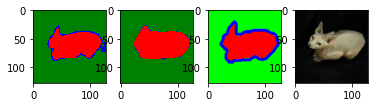

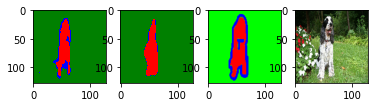

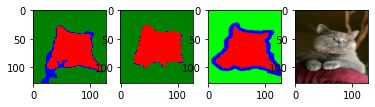

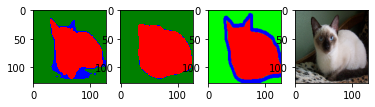

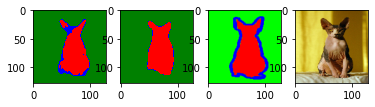

In [26]:
#showm some results
#the one considering soft labels is better than the one without soft labels, especeiall for the bound areas
colors = ['red', 'blue', 'green']#red=pet, green=background, blue=bounds
cmap = mpl.colors.ListedColormap(colors)

plt.figure()
for i in range(5):
    plt.subplot(141)
    plt.imshow(np.squeeze(mask_label_train_yes_soft[i]), cmap=cmap)
    plt.subplot(142)
    plt.imshow(np.squeeze(mask_label_train_no_soft[i]), cmap=cmap)
    plt.subplot(143)
    plt.imshow(np.squeeze(train_y[i]), cmap=cmap)
    plt.subplot(144)
    plt.imshow(train_x[i])
    plt.show()